In [1]:
import env
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Activation, LeakyReLU, BatchNormalization, Input, AveragePooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
print("Imported")

Imported


In [2]:
config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.3))
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.3
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)
print("START123")

START123


In [3]:
X = np.load(env.FEATURES_PATH)
Y = np.load(env.LABELS_PATH)
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.01)

print("LOADED")
print(x_train.shape)
print(y_train.shape)

LOADED
(1000, 224, 224, 3)
(1000, 5)


In [30]:
#Restnet50
print("preparing model...")
base = ResNet50(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
#weights="imagenet",
new_model = base.output
new_model = MaxPool2D(pool_size=(7, 7))(new_model)
new_model = Flatten(name="flatten")(new_model)
new_model = Dense(256)(new_model)
new_model = LeakyReLU(0.1)(new_model)
new_model = Dropout(0.1)(new_model)
new_model = Dense(5, activation="softmax")(new_model)
new_model = Activation('softmax')(new_model)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=base.input, outputs=new_model)

#Make the pre trained layers untrainable
for layer in base.layers:
    layer.trainable = False
print("DONE")

preparing model...
DONE


In [31]:
epochs = 30
learning_rate = 0.0001
decay_rate = learning_rate / epochs
momentum = 0.2
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
adam = tf.keras.optimizers.Adam(lr = learning_rate, decay=decay_rate)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
#kullback_leibler_divergence
#categorical_crossentropy
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [32]:
#with tf.device('/cpu:0'):
trained = model.fit(x_train, y_train, batch_size=32, epochs=epochs, validation_split = 0.2, shuffle = True)

Epoch 1/30
25/25 [==============================] - 7s 182ms/step - loss: 1.6762 - accuracy: 0.1205 - val_loss: 1.6098 - val_accuracy: 0.1650
Epoch 2/30
25/25 [==============================] - 4s 148ms/step - loss: 1.5625 - accuracy: 0.3213 - val_loss: 1.3201 - val_accuracy: 0.6750
Epoch 3/30
25/25 [==============================] - 4s 149ms/step - loss: 1.3534 - accuracy: 0.6275 - val_loss: 1.2564 - val_accuracy: 0.6750
Epoch 4/30
25/25 [==============================] - 4s 149ms/step - loss: 1.3232 - accuracy: 0.6079 - val_loss: 1.2441 - val_accuracy: 0.6750
Epoch 5/30
25/25 [==============================] - 4s 149ms/step - loss: 1.3135 - accuracy: 0.6058 - val_loss: 1.2396 - val_accuracy: 0.6750
Epoch 6/30
25/25 [==============================] - 4s 149ms/step - loss: 1.2907 - accuracy: 0.6246 - val_loss: 1.2374 - val_accuracy: 0.6750
Epoch 7/30
25/25 [==============================] - 4s 149ms/step - loss: 1.2999 - accuracy: 0.6171 - val_loss: 1.2357 - val_accuracy: 0.6750
Epoch 

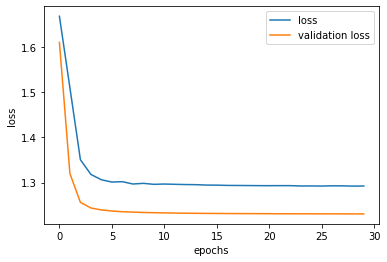

In [33]:
plt.plot(trained.history['loss'], label="loss")
plt.plot(trained.history['val_loss'], label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

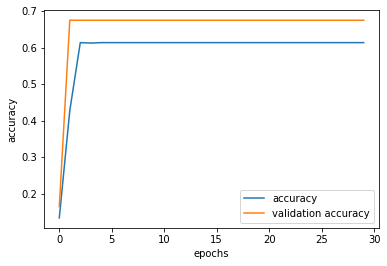

In [42]:
plt.plot(trained.history['accuracy'], label="accuracy")
plt.plot(trained.history['val_accuracy'], label="validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

In [25]:
#with tf.device('/cpu:0'):
x_test = np.load(f"{base_path}x_test.npy")
y_test = np.load(f"{base_path}y_test.npy")
print(x_test.shape)
print(y_test.shape)
print(model.evaluate(x=x_test, y=y_test))
print("DONE")

(100, 224, 224, 3)
(100, 5)
4/4 [==============================] - 1s 217ms/step - loss: 1.3056 - accuracy: 0.6000
[1.3056339025497437, 0.6000000238418579]
DONE


Confusion matrix : 
 [[[96  0]
  [ 4  0]]

 [[89  0]
  [11  0]]

 [[86  0]
  [14  0]]

 [[40  0]
  [60  0]]

 [[89  0]
  [11  0]]]


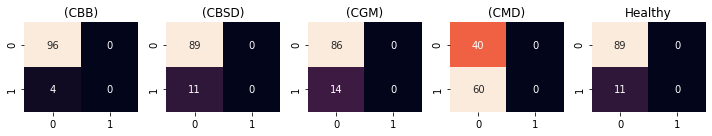

In [43]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

#with tf.device('/cpu:0'):
y_hat = model.predict(x_test)
# confusion matrix
matrix = multilabel_confusion_matrix(y_test,  y_hat.round())
print('Confusion matrix : \n',matrix)

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
sns.heatmap(matrix[0], annot=True, fmt="d", cbar=False,ax=axes[0])
axes[0].set_title('(CBB)')
sns.heatmap(matrix[1], annot=True, fmt="d", cbar=False,ax=axes[1])
axes[1].set_title('(CBSD)')
sns.heatmap(matrix[2], annot=True, fmt="d", cbar=False,ax=axes[2])
axes[2].set_title('(CGM)')
sns.heatmap(matrix[3], annot=True, fmt="d", cbar=False,ax=axes[3])
axes[3].set_title('(CMD)')
sns.heatmap(matrix[4], annot=True, fmt="d", cbar=False,ax=axes[4])
axes[4].set_title('Healthy')
fig.tight_layout()
plt.show()

    #print(y_test)
